In [23]:
import numpy as np, matplotlib.pyplot as plt
from numpy import *
import pylab
import scipy as scipy
from scipy.io import wavfile
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
import IPython
import cmath

# STFT Implementation from Lab1

In [24]:
def stft(input_sound, dft_size, hop_size, zero_pad, window):

    # Forward tranform
    if(input_sound.ndim is 1):
        # Zero Pad the signal
        length_input_sound = len(input_sound)
        remainder = (length_input_sound - dft_size)%hop_size
        padded_input = append(input_sound,zeros(hop_size-remainder))
        padded_input = append(zeros(dft_size), padded_input)

        # Calculcate FFTs using analysis(hamming) window
        X = np.array([np.fft.rfft(window*padded_input[i:i+dft_size], dft_size + zero_pad) 
                        for i in range(0, len(padded_input)-dft_size+1, hop_size)])
        X = X.T
        
        return X
        
    # Inverse transform
    else:
        #Restore original shape
        waveform = np.zeros(dft_size + (input_sound.shape[1]-1)*hop_size)
        X = input_sound.T
        
        for n,i in enumerate(range(0, len(waveform)-dft_size-zero_pad+1, hop_size)):
            waveform[i:i+dft_size+zero_pad] += np.real(np.fft.irfft(X[n]))
            
        for i in range(0, len(waveform)-dft_size + 1, hop_size):
            waveform[i:i+dft_size] = waveform[i:i+dft_size]
        
        return waveform

# Initialization

In [25]:
samplerate, sound = wavfile.read('array.wav')
sound = sound.T
IPython.display.display(IPython.display.Audio(sound[0], rate=samplerate))

angle_range = np.linspace(0, np.pi, 50)
steering_vector = np.zeros((513, 50, 8), dtype=complex_)

# Steering Vector

In [26]:
r = 0.1
R = samplerate
C = 345
N = 1024

for mic_idx in range(8):
    for i, angle in enumerate(angle_range):
        for k in range(513):
            steering_vector[k, i, mic_idx] = np.exp((-1j)*(mic_idx)*(0.1 * np.cos(angle))*(2*np.pi*(k+1))*(R)/float(C*N))

# Localization

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


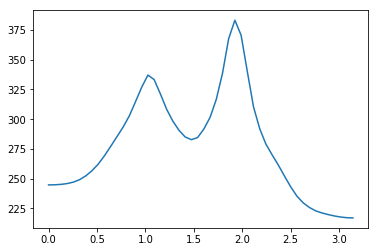

In [28]:
final_output = np.zeros((513, 391, 50), dtype = complex_)
for mic_idx in range(8):
    channel = sound[mic_idx]
    dfts = stft(channel, 1024, 256, 0, np.hanning(1024))
    
    for i,angle in enumerate(angle_range):
        extract = steering_vector[:, i, mic_idx]
        conjugate = np.conj(extract)
        x = np.multiply(dfts.T, conjugate).T
        final_output[:, :, i] = final_output[:, :, i] + x
        
        
rms = np.zeros((50), dtype = complex_)
for i, angle in enumerate(angle_range):
    rms[i] = np.sqrt(np.sum(np.abs(final_output[:, :, i]))/float(513*391))
    
plt.plot(angle_range, rms)
plt.show()

# Beamforming

In [29]:
#Largest peak at index 25 and second largest at 39
thetas = np.array([angle_range[16], angle_range[30]])
thet_indices = np.array([16, 30])
steering_vectors = [steering_vector[:, 16, :], steering_vector[:, 30, :]]

In [30]:
final_audio1 = np.zeros((513, 391, 8), dtype = complex_)
#Audio 1
for mic_idx in range(8):
    channel = sound[mic_idx]
    dfts = stft(channel, 1024, 256, 0, np.hanning(1024))
    final_output[:, :, mic_idx] = np.multiply(dfts.T, np.conj(steering_vectors[0][:, mic_idx])).T
    
final_audio1 = np.zeros((513, 391), dtype = complex_)
for i in range(8):
    final_audio1 = final_audio1 + final_output[:, :, i]
waveform1 = stft(final_audio1, 1024, 256, 0, np.hanning(1024))

In [31]:
final_audio2 = np.zeros((513, 391, 8), dtype = complex_)
#Audio 1
for mic_idx in range(8):
    channel = sound[mic_idx]
    dfts = stft(channel, 1024, 256, 0, np.hanning(1024))
    final_output[:, :, mic_idx] = np.multiply(dfts.T, np.conj(steering_vectors[1][:, mic_idx])).T
    
final_audio2 = np.zeros((513, 391), dtype = complex_)
for i in range(8):
    final_audio2 = final_audio2 + final_output[:, :, i]
waveform2 = stft(final_audio2, 1024, 256, 0, np.hanning(1024))

# Enhanced Audio

In [32]:
IPython.display.display(IPython.display.Audio(waveform1, rate=samplerate))

In [33]:
IPython.display.display(IPython.display.Audio(waveform2, rate=samplerate))